# Задание

## Определение доходности облигаций по данным ММВБ

Имеются данные по облигациям, которые торгуются на ММВБ на текущую дату.

Требуется выполнить следующие действия с данными по облигациям на дату формирования данных:
    
1) Оценить рынок рублевых облигаций по распределению купонной доходности, предложить разделение на кластеры по купонной доходности. 
Предложить графическое представление полученных групп/кластеров. (график)

2) По низкорисковым рублевым облигациям с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигациям выпущенным в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей дата. (график и/или таблица). 

3) Допускается обоснованное изменение условий как по критериям оценки рынка, так с учетом выбранной стратегии инвестирования.

Датасет с данными расположен по адресу: https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru
 
На усмотрение слушателя:
- можно скачать и загрузить в вашем скрипте файл csv  (например, pd.read_csv с указанием русской кодировки, релевантного знака сепарирования и номера строки заголовков),
- загружать on-line:
 s=requests.get(bond_url).content
pd.read_csv(io.StringIO(s.decode('УКАЗАТЬ КОДИРОВКУ')), sep='СЕПАПРАТОР', header=№ СТРОКИ ЗАГОЛОВКОВ)

Могут быть использованы следующие поля (а также все остальные) в любых комбинациях:
    
'SECID' - Код ценной бумаги, 

'SHORTNAME' - Краткое наименование,

'NAME' Полное наименование, 

'FACEVALUE' - Номинальная стоимость, 

FACEUNIT' - валюта, 

'DURATION' - дюрация,

'IS_QUALIFIED_INVESTORS' - признак продукта для квалифицированных инвесторов, 

'HIGH_RISK' - признак уровня риска, 

'COUPONFREQUENCY' – число купонов в год, 

'COUPONDATE' - Дата выплаты купона,

 'COUPONPERCENT' - Ставка купона, %, 
    
'COUPONVALUE' - Сумма купона, в валюте номинала, 

'OFFERDATE' - Дата оферты, 

'EMITENTNAME' – наименование эмитента,

'INN' – ИНН эмитента,

'PRICE' – текущий % от FACEVALUE, 

'PRICE_RUB' - котировка,
 
Пояснения:
    
1) Для получения текущей даты можно использовать метод  datetime.date.today();

2) Период расчета доходности рекомендуется выбирать 365 дней с текущей даты;

3) Нужно учитывать накопленный купонный доход (НКД) и разницу котировки и номинала ;

4) Расчет доходности можно посмотреть, например, здесь: https://www.banki.ru/blog/BAY/10702.php
        
(Доход) = (Цена облигации при продаже) + (НКД на момент продажи)

(Расходы) = (Цена облигации при покупке) + (НКД на момент покупки)+(Комиссии за приобретение, реализацию, хранение)

Комиссии Сбера зависят от тарифа, объема сделок и пр. Подробнее см. здесь: https://www.sberbank.ru/ru/person/investments/broker_service/tarifs

В общем случае считаем налог доход при ставке НДФЛ 13% (при желании можно считать 15%) и комиссию брокера 0.06%
Комиссию Биржи принимаем в 0.0125%. 

Profit =  (((Цена_Номинальная  – Цена_покупки )*(1 ЕСЛИ ≤0│0.87 ЕСЛИ>0)  –  НКД + 0.87*Купонный_доход_руб*X_лет)*100% )
/ 
((Цена_покупки+ НКД)*(1+Комиссия брокера в процентах/100 +Комиссия биржи/100))

- Период расчета НКД:  df['COUPONDAYSPASSED']/df['COUPONLENGTH'] , рекомендуется выбирать меньше или равный  0.2.
Если удовлетворяет условию, полученная величина умножается на COUPONPERCENT/COUPONFREQUENCY.
- Датасет содержит данные, которые нужно преобразовывать в форматы python, а также пустые и искаженные данные, с которыми тоже нужно что-то решить.

In [176]:
# библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import datetime
from datetime import datetime, date
import html5lib

import warnings
warnings.filterwarnings('ignore')

In [177]:
# загружаем on-line датасет по облигациям, которые торгуются на ММВБ на текущую дату
url ="https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('cp1251')) , sep=';', header=1)
df

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED
0,AMUNIBB2AER2,UBANK11/22,UNIBANK OJSC Series 1,Корпоративные еврооблигации,AMUNIBB2AER2,NaN,3.0,"100,0",USD,10000.0,...,"0,0","12014,86","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
1,AMUNIBB2DER6,UBANK02/24,UNIBANK OJSC Series 1 21,Корпоративные еврооблигации,AMUNIBB2DER6,NaN,3.0,"100,0",USD,33478.0,...,"0,0","12153,74","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2,AT0000A2UF10,Raiff CAG,Raiffeisen Centrobank AG,Корпоративные еврооблигации,AT0000A2UF10,NaN,3.0,"1000,0",USD,50000.0,...,"0,0","99993,96","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
3,CH0248531110,VTB-24 CHF,VTB CAPITAL S.A. 24 CHF,Корпоративные еврооблигации,CH0248531110,NaN,NaN,"5000,0",CHF,70000.0,...,"0,0","650369,52","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
4,CH0379268748,RZD-23 CHF,RZD Capital PLC 23 CHF,Корпоративные еврооблигации,CH0379268748,NaN,NaN,"5000,0",CHF,90000.0,...,"0,0","396830,38","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,XS2420560869,BCS01/25,BCS SP Plc Series 239,Корпоративные еврооблигации,XS2420560869,NaN,3.0,"100000,0",RUB,700.0,...,"0,0","200000,0","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2663,XS2423361190,BCS02/27-4,BCS SP Plc Series 240,Корпоративные еврооблигации,XS2423361190,NaN,3.0,"1250,0",USD,8000.0,...,"0,0","149646,44","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2664,XS2429208486,BCS05/25,BCS SP Plc Series 243,Корпоративные еврооблигации,XS2429208486,NaN,3.0,"1250,0",USD,8000.0,...,"0,0","138712,42","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2665,XS2439218640,BCS06/25-B,BCS SP Plc Series 244,Корпоративные еврооблигации,XS2439218640,NaN,3.0,"1250,0",USD,8000.0,...,"0,0","146111,6","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0


# Описание колонок

1	SECID	Инструмент

2	SHORTNAME	Краткое наименование цб

3	NAME	Полное Наименование цб

4	TYPENAME	Тип ценной бумаги

5	ISIN	ISIN

6	REGNUMBER	Государственный регистрационный номер

7	LISTLEVEL	Уровень листинга

8	FACEVALUE	Номинальная стоимость

9	FACEUNIT	Валюта номинала

10	ISSUESIZE	Объем выпуска, бумаг

11	IS_COLLATERAL	Внешняя бумага

12	IS_EXTERNAL	признак внешняя ЦБ

13	PRIMARY_BOARDID	Идентификатор главного режима торгов

14	PRIMARY_BOARD_TITLE	Главный режим торгов

15	MATDATE	Дата погашения

16	IS_RII	Признак сектора РИИ

17	EVENINGSESSION	вечерняя сессия

18	MORNINGSESSION	утренняя сессия

19	DURATION	дюрация / эффективный срок до погашения облигации

20	IS_QUALIFIED_INVESTORS	Для квалифицированных инвесторов

21	HIGH_RISK	признак уровня риска

22	COUPONFREQUENCY	Частота выплаты купонов в год / число купонов в год

23	YIELDATWAP	Ставка ближайшего купона, %

24	COUPONDATE	Дата выплаты купона

25	COUPONPERCENT	Ставка купона, %, 

26	COUPONVALUE	Размер ближайшего купона, в валюте номинала / Сумма купона, в валюте номинала

27	COUPONDAYSPASSED	Купонный период - сколько прошло, дн

28	COUPONDAYSREMAIN	Купонный период - сколько осталось, дн

29	COUPONLENGTH	Купонный период, дн

30	ISSUEDATE	Дата начала торгов

31	INITIALFACEVALUE	Первоначальная номинальная стоимость

32	SECSUBTYPE	Класс облигации

33	STARTDATEMOEX	Дата начала торгов на Московской Бирже

34	DAYSTOREDEMPTION	дней до погашения

35	OFFERDATE	Дата оферты

36	EMITENTNAME	Эмитент

37	INN	ИНН эмитента

38	LOTSIZE	Размер лота на основном режиме торгов

39	PRICE	Расчетная цена / текущий % от FACEVALUE

40	PRICE_RUB	Расчетная цена, руб / котировка

41	RTL1	Нижняя граница рыночного риска, руб. (RTL1)

42	RTH1	Верхняя граница рыночного риска, руб. (RTH1)

43	RTL2	Нижняя граница рыночного риска, руб. (RTL2)

44	RTH2	Верхняя граница рыночного риска, руб. (RTH2)

45	RTL3	Нижняя граница рыночного риска, руб. (RTL3)

46	RTH3	Верхняя граница рыночного риска, руб. (RTH3)

47	DISCOUNT1	Ставка рыночного риска 1 (S1)

48	LIMIT1	Лимит концентрации 1, шт. (L1)

49	DISCOUNT2	Ставка рыночного риска 2 (S2)

50	LIMIT2	Лимит концентрации 2, шт. (L2)

51	DISCOUNT3	Ставка рыночного риска 3 (S3)

52	DISCOUNTL0	Инд. ставка падения (S0_L)

53	DISCOUNTH0	Инд. ставка роста (S0_H)

54	FULLCOVERED	Запрет коротких продаж

In [178]:
# описательная характеристика датасета
df.describe(include = "all")

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED
count,2667,2667,2667,2667,2667,2282,2398.000000,2667,2667,2.648000e+03,...,2481,2481,2667,8.870000e+02,887,8.870000e+02,887,2481,2481,2481.000000
unique,2667,2667,2667,9,2667,2282,NaN,163,6,NaN,...,833,2268,48,NaN,50,NaN,51,52,42,NaN
top,AMUNIBB2AER2,UBANK11/22,UNIBANK OJSC Series 1,Биржевые облигации,AMUNIBB2AER2,4-01-10013-R,NaN,"1000,0",RUB,NaN,...,"0,0","2000,0","100,0",NaN,"18,0",NaN,"22,0","10,00000","10,00000",NaN
freq,1,1,1,1637,1,1,NaN,2139,2288,NaN,...,1624,43,1780,NaN,79,NaN,80,900,1434,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.386572,NaN,NaN,3.276314e+08,...,NaN,NaN,NaN,3.492001e+05,NaN,1.745401e+06,NaN,NaN,NaN,0.642080
std,NaN,NaN,NaN,NaN,NaN,NaN,0.845279,NaN,NaN,4.189619e+09,...,NaN,NaN,NaN,8.379265e+05,NaN,4.189823e+06,NaN,NaN,NaN,0.479485
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000e+00,...,NaN,NaN,NaN,1.700000e+01,NaN,8.500000e+01,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,2.940735e+05,...,NaN,NaN,NaN,1.000000e+05,NaN,5.000000e+05,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,2.000000e+06,...,NaN,NaN,NaN,2.000000e+05,NaN,1.000000e+06,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,1.000000e+07,...,NaN,NaN,NaN,3.000000e+05,NaN,1.500000e+06,NaN,NaN,NaN,1.000000


In [179]:
# смотрим уникальность колонок
df.nunique()

SECID                     2667
SHORTNAME                 2667
NAME                      2667
TYPENAME                     9
ISIN                      2667
REGNUMBER                 2282
LISTLEVEL                    3
FACEVALUE                  163
FACEUNIT                     6
ISSUESIZE                 1022
IS_COLLATERAL                2
IS_EXTERNAL                  2
PRIMARY_BOARDID             11
PRIMARY_BOARD_TITLE         11
MATDATE                   1516
IS_RII                       1
DURATION                   957
EVENINGSESSION               2
MORNINGSESSION               1
IS_QUALIFIED_INVESTORS       2
HIGH_RISK                    2
COUPONFREQUENCY              8
YIELDATWAP                 613
COUPONDATE                 473
COUPONPERCENT              439
COUPONVALUE                958
COUPONDAYSPASSED           446
COUPONDAYSREMAIN           473
COUPONLENGTH               123
ISSUEDATE                 1152
INITIALFACEVALUE            25
SECSUBTYPE                   3
STARTDAT

In [180]:
# смотрим инфу по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SECID                   2667 non-null   object 
 1   SHORTNAME               2667 non-null   object 
 2   NAME                    2667 non-null   object 
 3   TYPENAME                2667 non-null   object 
 4   ISIN                    2667 non-null   object 
 5   REGNUMBER               2282 non-null   object 
 6   LISTLEVEL               2398 non-null   float64
 7   FACEVALUE               2667 non-null   object 
 8   FACEUNIT                2667 non-null   object 
 9   ISSUESIZE               2648 non-null   float64
 10  IS_COLLATERAL           2667 non-null   int64  
 11  IS_EXTERNAL             2667 non-null   int64  
 12  PRIMARY_BOARDID         2667 non-null   object 
 13  PRIMARY_BOARD_TITLE     2667 non-null   object 
 14  MATDATE                 2615 non-null   

In [181]:
#  считаем количестово пропущенных значений
df.isna().sum()

SECID                        0
SHORTNAME                    0
NAME                         0
TYPENAME                     0
ISIN                         0
REGNUMBER                  385
LISTLEVEL                  269
FACEVALUE                    0
FACEUNIT                     0
ISSUESIZE                   19
IS_COLLATERAL                0
IS_EXTERNAL                  0
PRIMARY_BOARDID              0
PRIMARY_BOARD_TITLE          0
MATDATE                     52
IS_RII                    2653
DURATION                  1088
EVENINGSESSION               0
MORNINGSESSION               0
IS_QUALIFIED_INVESTORS       0
HIGH_RISK                    0
COUPONFREQUENCY            359
YIELDATWAP                1556
COUPONDATE                  13
COUPONPERCENT              138
COUPONVALUE                136
COUPONDAYSPASSED            14
COUPONDAYSREMAIN            13
COUPONLENGTH                14
ISSUEDATE                  151
INITIALFACEVALUE             0
SECSUBTYPE                2513
STARTDAT

Text(0.5, 1.0, 'Пропущенные значения')

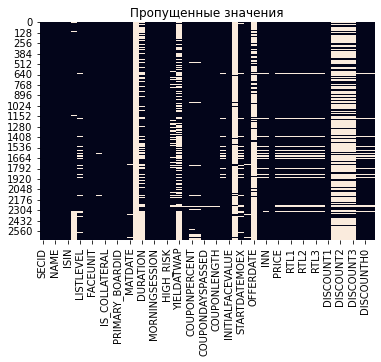

In [182]:
# строим график пропущенных значений
sns.heatmap(df.isnull(), cbar = False).set_title("Пропущенные значения")

In [183]:
# количество столбцов, которые имеют хотя бы одно пропущенное значение
len(df.columns[df.isna().any()].tolist())

36

# Выводы по датасету и по пропущенным значениям

1 REGNUMBER - Государственный регистрационный номер 

2 LISTLEVEL - Уровень листинга (оценка биржей надежности бумаг) 

3 ISSUESIZE - Объем выпуска, бумаг (шт. коммерческих облигаций)

4 MATDATE - Дата погашения ( шт. количество бессрочных облигаций)

5 IS_RII - Признак сектора РИИ (Рынок инноваций и инвестиций)

6 DURATION - Дюрация / эффективный срок до погашения облигации (средневзвешенный срок потока платежей). Рассчитывается по формуле - D = Σi (PVi * ti) / Σi (PVi), где: PV — поступление по облигации t — время поступления. Дюарация расчитана по тем облигациям, которые имеют постоянный купон, остальные облигации с переменным купоном.

7 COUPONFREQUENCY - Частота выплаты купонов в год / число купонов в год - шт. облигаций, которые либо безкуппонные (дисконтная облигация), либо выплата купона происходит один раз в конце погашения облигации (премиальная c премией)

8 YIELDATWAP  -  Доходность по средневзвешенной цене купона   

9 COUPONDATE -  Дата выплаты купона -  шт. облигаций бескупонные (дисконтные). В результате согласно COUPONFREQUENCY - COUPONDATE = количество облигаций, по которым выплата купона (премии) происходит один раз в конце погашения облигации (премиальная c премией)

10 COUPONPERCENT - Ставка купона, % - облигации по которым отсутствуют купонные выплаты (либо по котрым уже выплатили все предполагаемые купоны)

11 COUPONVALUE - Размер ближайшего купона, в валюте номинала - облигации по которым отсутствуют купонные выплаты (либо по котрым уже выплатили все предполагаемые купоны)

12 COUPONDAYSPASSED - Купонный период - сколько прошло, дн - шт. облигаций бескупонные (дисконтные)

13 COUPONDAYSREMAIN - Купонный период - сколько осталось, дн -  шт. облигаций бескупонные (дисконтные)

14 COUPONLENGTH -  Общий купонный период, дн - 17 шт. облигаций бескупонные (дисконтные)

15 ISSUEDATE - Дата начала торгов          

16 SECSUBTYPE - Класс облигации 

17 STARTDATEMOEX - Дата начала торгов на Московской Бирже 

18 DAYSTOREDEMPTION -  Количество дней до погашения (52 шт. бессрочные облигации)

19 OFFERDATE - Дата оферты - это дата, в которую можно досрочно погасить номинал облигации.

20 EMITENTNAME - Эмитент - (151 шт. коммерческих облигаций)

21 INN - ИНН Эмитент ( шт. коммерческих облигаций +  иностраных компаний)

22 PRICE - Расчетная (рыночная) цена / текущий % от FACEVALUE ( шт. облигаций по которым не идут торги)

23 PRICE_RUB - Расчетная цена, руб / котировка ( шт. облигаций по которым не идут торги)

24 RTL1 - Нижняя граница рыночного риска, руб. (RTL1)

25 RTH1 - Верхняя граница рыночного риска, руб. (RTH1)

26 RTL2 - Нижняя граница рыночного риска, руб. (RTL2)

27 RTH2 - Верхняя граница рыночного риска, руб. (RTH2)

28 RTL3 - Нижняя граница рыночного риска, руб. (RTL3) 

29 RTH3  - Верхняя граница рыночного риска, руб. (RTH3) 

30 LIMIT1 - Лимит концентрации 1, шт. (L1)

31 DISCOUNT2 - Лимит концентрации 1, шт. (L1)

32 LIMIT2  - Лимит концентрации 2, шт. (L2) 

33 DISCOUNT3 -  Ставка рыночного риска 3 (S3)

34 DISCOUNTL0 - Инд. ставка падения (S0_L)

35 DISCOUNTH0 - Инд. ставка роста (S0_H)

36 FULLCOVERED - Запрет коротких продаж

37 LOTSIZE - Размер лота на основном режиме торгов

# Решение. Часть №1

1) Оценить рынок рублевых облигаций по распределению купонной доходности, предложить разделение на кластеры по купонной доходности.
Предложить графическое представление полученных групп/кластеров. (график)

In [184]:
# количество облигаций относительно валюты номинала
df.FACEUNIT.value_counts()

RUB    2288
USD     322
EUR      45
CHF       8
CNY       2
GBP       2
Name: FACEUNIT, dtype: int64

In [185]:
# выбираем рублевые облигации
rub = df.loc[df.FACEUNIT == 'RUB']
rub

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED
12,RU000A0JQ5C5,НПФ 01,"""НПФ"" ООО об.сер. 01",Корпоративные облигации,RU000A0JQ5C5,4-01-10013-R,3.0,"1000,0",RUB,40800.0,...,"0,0","3331,24","100,0",NaN,NaN,NaN,NaN,"10,00000","10,00000",1.0
13,RU000A0JQ7Z2,РЖД-19 обл,"""Российские ЖД"" ОАО 19 обл.",Корпоративные облигации,RU000A0JQ7Z2,4-19-65045-D,2.0,"1000,0",RUB,10000000.0,...,"794,89","1217,49","15,0",200000.0,"18,0",1000000.0,"21,0","10,00000","10,00000",0.0
14,RU000A0JQAL8,ДОМ.РФ14об,ДОМ.РФ (АО) обл. сер. А14,Корпоративные облигации,RU000A0JQAL8,4-14-00739-A,1.0,"1000,0",RUB,7000000.0,...,"879,01","1264,91","12,0",140000.0,"15,0",700000.0,"18,0","10,00000","10,00000",0.0
15,RU000A0JQAM6,ДОМ.РФ15об,ДОМ.РФ (АО) обл. сер. А15,Корпоративные облигации,RU000A0JQAM6,4-15-00739-A,1.0,"1000,0",RUB,7000000.0,...,"577,43","1732,29","40,0",200000.0,"45,0",1000000.0,"50,0","10,00000","10,00000",0.0
16,RU000A0JQRD9,РЖД-23 обл,"""Российские ЖД"" ОАО 23 обл.",Корпоративные облигации,RU000A0JQRD9,4-23-65045-D,2.0,"1000,0",RUB,15000000.0,...,"768,88","1228,2","17,0",300000.0,"20,0",1500000.0,"23,0","10,00000","10,00000",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,XS2368111584,ALFA-25 RU,Alfa Bond Issuance 04/08/25,Корпоративные еврооблигации,XS2368111584,NaN,NaN,"100000,0",RUB,100000.0,...,"70608,78","112790,66","17,0",2000.0,"20,0",10000.0,"23,0","17,00000","17,00000",1.0
2636,XS2388458403,BCS12/26-2,BCS SP Plc Series 215,Корпоративные еврооблигации,XS2388458403,NaN,3.0,"100000,0",RUB,5000.0,...,"0,0","120540,0","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2655,XS2415466676,BCS11/24-8,BCS SP Plc Series 229,Корпоративные еврооблигации,XS2415466676,NaN,3.0,"100000,0",RUB,3000.0,...,"0,0","182640,0","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2658,XS2417535650,BCS06/25-A,BCS SP Plc Series 234,Корпоративные еврооблигации,XS2417535650,NaN,3.0,"100000,0",RUB,700.0,...,"0,0","200000,0","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0


In [186]:
# выбираем небходимые колонки
bond = rub[['SECID', 'SHORTNAME', 'TYPENAME', 'ISIN', 'MATDATE', 'FACEVALUE', 'HIGH_RISK',
    'COUPONFREQUENCY', 'COUPONDATE', 'COUPONPERCENT', 'COUPONVALUE', 'COUPONDAYSPASSED',
     'COUPONDAYSREMAIN', 'COUPONLENGTH', 'OFFERDATE', 'PRICE', 'PRICE_RUB']].reset_index()
bond = bond.drop(['index'],axis=1)
bond

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,OFFERDATE,PRICE,PRICE_RUB
0,RU000A0JQ5C5,НПФ 01,Корпоративные облигации,RU000A0JQ5C5,06.05.2029,"1000,0",1,NaN,06.05.2029,"5,000","1000,55",4858.0,2446.0,7304.0,NaN,"100,0","1665,62"
1,RU000A0JQ7Z2,РЖД-19 обл,Корпоративные облигации,RU000A0JQ7Z2,08.07.2024,"1000,0",0,2.0,09.01.2023,"7,850","39,14",45.0,137.0,182.0,NaN,"99,63","1006,19"
2,RU000A0JQAL8,ДОМ.РФ14об,Корпоративные облигации,RU000A0JQAL8,15.05.2023,"1000,0",0,2.0,15.11.2022,"16,500","83,18",102.0,82.0,184.0,NaN,"102,54","1071,96"
3,RU000A0JQAM6,ДОМ.РФ15об,Корпоративные облигации,RU000A0JQAM6,15.09.2028,"1000,0",0,2.0,15.09.2022,"20,000","100,82",163.0,21.0,184.0,NaN,"106,5","1154,86"
4,RU000A0JQRD9,РЖД-23 обл,Корпоративные облигации,RU000A0JQRD9,16.01.2025,"1000,0",0,2.0,19.01.2023,"7,850","39,14",35.0,147.0,182.0,NaN,"99,08","998,54"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,XS2368111584,ALFA-25 RU,Корпоративные еврооблигации,XS2368111584,04.08.2025,"100000,0",0,2.0,04.02.2023,"7,850","3925,0",21.0,163.0,184.0,NaN,"91,22","91699,72"
2284,XS2388458403,BCS12/26-2,Корпоративные еврооблигации,XS2388458403,30.12.2026,"100000,0",0,2.0,30.12.2022,NaN,NaN,56.0,127.0,183.0,NaN,"60,27","60270,0"
2285,XS2415466676,BCS11/24-8,Корпоративные еврооблигации,XS2415466676,29.11.2024,"100000,0",0,1.0,29.11.2022,"0,010",NaN,248.0,96.0,344.0,NaN,"91,32","91320,0"
2286,XS2417535650,BCS06/25-A,Корпоративные еврооблигации,XS2417535650,01.06.2025,"100000,0",0,NaN,01.12.2022,NaN,NaN,238.0,98.0,336.0,NaN,"100,0","100000,0"


In [187]:
# изменяем форман с object на datetime
bond['COUPONDATE'] = pd.to_datetime(bond['COUPONDATE'], dayfirst=True)
bond['OFFERDATE'] = pd.to_datetime(bond['OFFERDATE'], dayfirst=True)
bond['MATDATE'] = pd.to_datetime(bond['MATDATE'], dayfirst=True)

In [188]:
# выбираем все бессрочные облигации и устанавливаем дату погашения как максимальную отметку времени
bond['MATDATE'].fillna(pd.Timestamp.max, inplace = True)

In [189]:
# выбираем облигации где нет оферты и устанавливаем дату оферты равной дате погашения 
bond.OFFERDATE.fillna(bond['MATDATE'], inplace = True)

In [190]:
# изменяем форман с object на float
bond['COUPONVALUE'] = bond['COUPONVALUE'].str.replace(',', '.').astype(float)
bond['COUPONPERCENT'] = bond['COUPONPERCENT'].str.replace(',', '.').astype(float)
bond['FACEVALUE'] = bond['FACEVALUE'].str.replace(',', '.').astype(float)
bond['PRICE'] = bond['PRICE'].str.replace(',', '.').astype(float)
bond['PRICE_RUB'] = bond['PRICE_RUB'].str.replace(',', '.').astype(float)

In [191]:
# выбираем все безкупонные облигации (дисконтные) и устанавливает % купонов по ним ноль
bond.loc[bond.COUPONDATE.isna(),'COUPONFREQUENCY'] = bond['COUPONFREQUENCY'].fillna(0, inplace = True)

In [192]:
# заменяем NaN на ноль по тем облигациям по которым отсутствуют купонные выплаты
# (либо по котрым уже выплатили все предполагаемые купоны)
bond.COUPONPERCENT.fillna(0, inplace = True)

In [193]:
# заменяем NaN на единицу по тем облигациям выплата купона (премии) происходит один раз в конце погашения облигации
bond.COUPONFREQUENCY.fillna(1, inplace = True) 

In [194]:
bond

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,OFFERDATE,PRICE,PRICE_RUB
0,RU000A0JQ5C5,НПФ 01,Корпоративные облигации,RU000A0JQ5C5,2029-05-06,1000.0,1,0.0,2029-05-06,5.00,1000.55,4858.0,2446.0,7304.0,2029-05-06,100.00,1665.62
1,RU000A0JQ7Z2,РЖД-19 обл,Корпоративные облигации,RU000A0JQ7Z2,2024-07-08,1000.0,0,2.0,2023-01-09,7.85,39.14,45.0,137.0,182.0,2024-07-08,99.63,1006.19
2,RU000A0JQAL8,ДОМ.РФ14об,Корпоративные облигации,RU000A0JQAL8,2023-05-15,1000.0,0,2.0,2022-11-15,16.50,83.18,102.0,82.0,184.0,2023-05-15,102.54,1071.96
3,RU000A0JQAM6,ДОМ.РФ15об,Корпоративные облигации,RU000A0JQAM6,2028-09-15,1000.0,0,2.0,2022-09-15,20.00,100.82,163.0,21.0,184.0,2028-09-15,106.50,1154.86
4,RU000A0JQRD9,РЖД-23 обл,Корпоративные облигации,RU000A0JQRD9,2025-01-16,1000.0,0,2.0,2023-01-19,7.85,39.14,35.0,147.0,182.0,2025-01-16,99.08,998.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,XS2368111584,ALFA-25 RU,Корпоративные еврооблигации,XS2368111584,2025-08-04,100000.0,0,2.0,2023-02-04,7.85,3925.00,21.0,163.0,184.0,2025-08-04,91.22,91699.72
2284,XS2388458403,BCS12/26-2,Корпоративные еврооблигации,XS2388458403,2026-12-30,100000.0,0,2.0,2022-12-30,0.00,NaN,56.0,127.0,183.0,2026-12-30,60.27,60270.00
2285,XS2415466676,BCS11/24-8,Корпоративные еврооблигации,XS2415466676,2024-11-29,100000.0,0,1.0,2022-11-29,0.01,NaN,248.0,96.0,344.0,2024-11-29,91.32,91320.00
2286,XS2417535650,BCS06/25-A,Корпоративные еврооблигации,XS2417535650,2025-06-01,100000.0,0,0.0,2022-12-01,0.00,NaN,238.0,98.0,336.0,2025-06-01,100.00,100000.00


In [195]:
bond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2288 entries, 0 to 2287
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SECID             2288 non-null   object        
 1   SHORTNAME         2288 non-null   object        
 2   TYPENAME          2288 non-null   object        
 3   ISIN              2288 non-null   object        
 4   MATDATE           2288 non-null   datetime64[ns]
 5   FACEVALUE         2288 non-null   float64       
 6   HIGH_RISK         2288 non-null   int64         
 7   COUPONFREQUENCY   2288 non-null   float64       
 8   COUPONDATE        2282 non-null   datetime64[ns]
 9   COUPONPERCENT     2288 non-null   float64       
 10  COUPONVALUE       2216 non-null   float64       
 11  COUPONDAYSPASSED  2281 non-null   float64       
 12  COUPONDAYSREMAIN  2282 non-null   float64       
 13  COUPONLENGTH      2281 non-null   float64       
 14  OFFERDATE         2288 n

In [196]:
bond.isna().sum()

SECID                 0
SHORTNAME             0
TYPENAME              0
ISIN                  0
MATDATE               0
FACEVALUE             0
HIGH_RISK             0
COUPONFREQUENCY       0
COUPONDATE            6
COUPONPERCENT         0
COUPONVALUE          72
COUPONDAYSPASSED      7
COUPONDAYSREMAIN      6
COUPONLENGTH          7
OFFERDATE             0
PRICE               158
PRICE_RUB           158
dtype: int64

In [197]:
# загружаем ставку ЦБ на сегодня
url = 'https://cbr.ru/hd_base/KeyRate/'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[0]
cb = df.iloc[0][1]/100
cb

8.0

In [198]:
# загружаем ставку RUONIA на сегодня (применима для облигаций с переменным купоном) для сравнения со ставкой ЦБ
url = 'https://cbr.ru/hd_base/ruonia/'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[0]
int(df.iloc[1][2]) / 100

7.96

In [199]:
# разобъем купонную ставку относительно ключевой ставки ЦБ, с учетом ставка ЦБ + 5% для налогооблажения
bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 0.1), (0.1, cb), (cb, cb+5), (cb+5, bond['COUPONPERCENT'].max()+1)])
bond['stavka'] = pd.cut(bond['COUPONPERCENT'], bins)
bond[['COUPONPERCENT','stavka']]

,COUPONPERCENT,stavka
0,5.00,"(0.1, 8.0]"
1,7.85,"(0.1, 8.0]"
2,16.50,"(13.0, 35.0]"
3,20.00,"(13.0, 35.0]"
4,7.85,"(0.1, 8.0]"
...,...,...
2283,7.85,"(0.1, 8.0]"
2284,0.00,"(-1.0, 0.0]"
2285,0.01,"(0.0, 0.1]"
2286,0.00,"(-1.0, 0.0]"


In [200]:
bond['stavka']

0         (0.1, 8.0]
1         (0.1, 8.0]
2       (13.0, 35.0]
3       (13.0, 35.0]
4         (0.1, 8.0]
            ...     
2283      (0.1, 8.0]
2284     (-1.0, 0.0]
2285      (0.0, 0.1]
2286     (-1.0, 0.0]
2287     (-1.0, 0.0]
Name: stavka, Length: 2288, dtype: category
Categories (5, interval[float64, right]): [(-1.0, 0.0] < (0.0, 0.1] < (0.1, 8.0] < (8.0, 13.0] < (13.0, 35.0]]

In [201]:
bond['stavka'].value_counts()

(8.0, 13.0]     773
(0.1, 8.0]      701
(0.0, 0.1]      510
(13.0, 35.0]    232
(-1.0, 0.0]      72
Name: stavka, dtype: int64

In [202]:
bond.groupby('stavka')['COUPONPERCENT'].agg(['min', 'max', 'mean', 'median', 'count'])

,min,max,mean,median,count
stavka,,,,,
"(-1.0, 0.0]",0.00,0.0,0.000000,0.000,72
"(0.0, 0.1]",0.01,0.1,0.012267,0.010,510
"(0.1, 8.0]",0.25,8.0,5.999612,6.800,701
"(8.0, 13.0]",8.02,13.0,10.142387,9.850,773
"(13.0, 35.0]",13.25,34.0,16.605655,15.625,232


[]

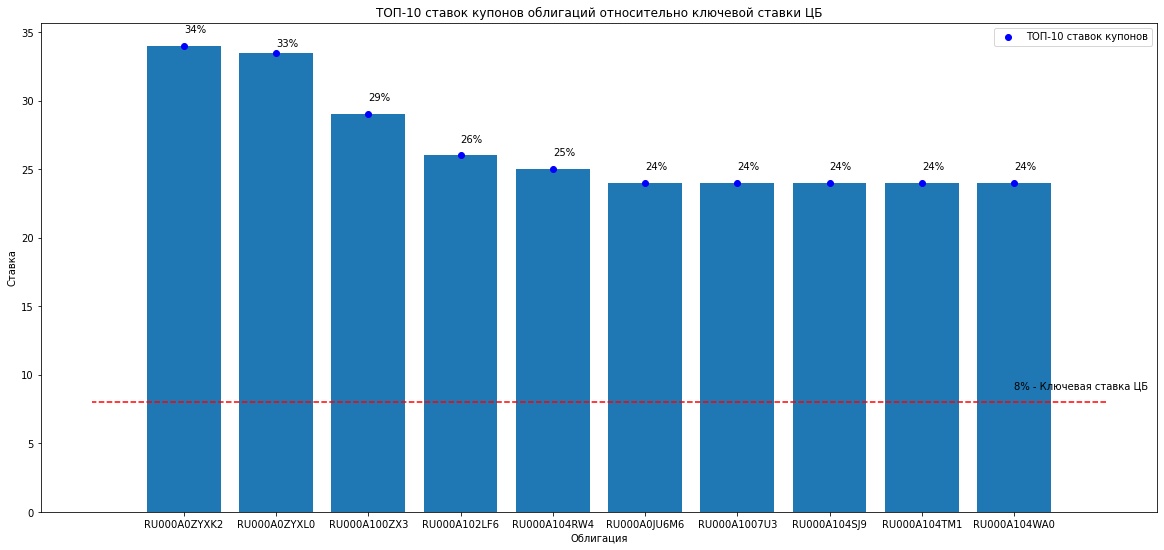

In [203]:
# строим график №1
q = bond[['COUPONPERCENT', 'ISIN']].nlargest(10, 'COUPONPERCENT')
q.index = q.ISIN
q = q.drop('ISIN', axis=1)

plt.figure(figsize=(20,9))

plt.bar(q.index,q.COUPONPERCENT)
plt.scatter(q.index,q.COUPONPERCENT, label='ТОП-10 ставок купонов', color="blue")
plt.plot((10,-1), (cb, cb), 'r--')

plt.ylabel("Ставка")
plt.xlabel("Облигация")

plt.title('ТОП-10 ставок купонов облигаций относительно ключевой ставки ЦБ')
plt.legend()
plt.text(cb+1, cb+1, '{}% - Ключевая ставка ЦБ'.format(int(cb)))

for i in range(0,q.shape[0]):
      plt.text(i, int(q.COUPONPERCENT[i])+1, "{}%".format(int(q.COUPONPERCENT[i])))
    
plt.plot()

In [204]:
# строим график №2
t1 = pd.DataFrame(bond[['stavka']].value_counts().reset_index()).sort_values('stavka')
t1.columns = ['stavka', 'count']
t1.index = range(1,t1.shape[0]+1)
fig = px.bar(t1, x = t1.index, y = 'count')
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Разбивка облигаций по размеру купона относительно ключевой ставки ЦБ",
                  xaxis_title="Группы", 
                  yaxis_title="Количество облигаций группы",
                  margin=dict(l=0, r=0, t=30, b=0),
                  annotations=[dict(text='1 группа - облигации безкупонные (0%)<br>2 группа - облигации с переменным(индексируемым) купоном (0.1%+)<br>3 группа облигации с купоном от 0.1 до ставки ЦБ<br>4 группа облигации с купоном от ставки ЦБ до ставка ЦБ+5%<br> 5 группа облигации с купоном более ставки ЦБ+5%', x=0.5, y=700, font_size=10, showarrow=False)]
                 
                 )

fig.show()

In [205]:
# строим график №3
fig = go.Figure()
fig.add_trace(go.Pie(values=t1['count'], labels=t1.index, sort = False))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Разбивка облигаций по размеру купона относительно ключевой ставки ЦБ",
                  xaxis_title="Группы", 
                  yaxis_title="Количество облигаций группы",
                  margin=dict(l=0, r=0, t=30, b=0),
                  annotations=[dict(text='1 группа - облигации безкупонные (0%)<br>2 группа - облигации с переменным(индексируемым) купоном (0.1%+)<br>3 группа облигации с купоном от 0.1 до ставки ЦБ<br>4 группа облигации с купоном от ставки ЦБ до ставки ЦБ+5%<br> 5 группа облигации с купоном более ставки ЦБ+5%', x=0, y=1, font_size=10, showarrow=False)])

fig.show()

In [206]:
# строим график №4
fig = px.scatter(bond[['COUPONFREQUENCY']], x = 'COUPONFREQUENCY')
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Разбивка облигаций по частоте выплаты купонов",
                  xaxis_title="Частота выплата купонов в год",
                  yaxis_title="ID",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [237]:
# строим график №6
t2 = pd.DataFrame(bond[['COUPONFREQUENCY']].value_counts().reset_index()).sort_values('COUPONFREQUENCY')
t2.columns = ['COUPONFREQUENCY', 'count']
t2.index = range(1,t2.shape[0]+1)
fig = go.Figure()
fig.add_trace(go.Pie(values=t2['count'], labels=t2.COUPONFREQUENCY, sort = False))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Разбиение облигаций по частоте выплаты купонов")
fig.show()

In [238]:
# строим график №5
fig = px.bar(t2, x = 'COUPONFREQUENCY', y = 'count')
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Разбивка облигаций по частоте выплаты купонов",
                  xaxis_title="Частота выплата купонов в год",
                  yaxis_title="Количество облигаций",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

# Решение. Часть №2

2) По низкорисковым рублевым облигациям с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигациям выпущенным в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей дата. (график и/или таблица).

In [209]:
# по 2 условию задания задаем датасет по низкорисковым рублевым облигациям
# с датой промежуточной выплаты по купонам не более 20% купонного периода

rb = bond.loc[(bond['COUPONDATE'].notna()) & (bond['HIGH_RISK'] != 1) & (bond['COUPONVALUE'].notna())
              & (bond['COUPONPERCENT'] != 0) & (bond['PRICE'].notna()) & (bond['COUPONDAYSPASSED']/bond['COUPONLENGTH']<=0.2)]

rb = rb.reset_index()
rb = rb.drop(['index'],axis=1)
rb

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,OFFERDATE,PRICE,PRICE_RUB,stavka
0,RU000A0JQRD9,РЖД-23 обл,Корпоративные облигации,RU000A0JQRD9,2025-01-16,1000.00,0,2.0,2023-01-19,7.85,39.14,35.0,147.0,182.0,2025-01-16,99.08,998.54,"(0.1, 8.0]"
1,RU000A0JS4J1,ЗСД 03,Корпоративные облигации,RU000A0JS4J1,2032-02-06,1000.00,0,2.0,2023-02-17,9.84,49.07,6.0,176.0,182.0,2032-02-06,108.43,1086.19,"(8.0, 13.0]"
2,RU000A0JS4K9,ЗСД 04,Корпоративные облигации,RU000A0JS4K9,2032-02-06,1000.00,0,2.0,2023-02-17,9.84,49.07,6.0,176.0,182.0,2032-02-06,111.70,1118.89,"(8.0, 13.0]"
3,RU000A0JS4L7,ЗСД 05,Корпоративные облигации,RU000A0JS4L7,2032-02-06,1000.00,0,2.0,2023-02-17,9.84,49.07,6.0,176.0,182.0,2032-02-06,110.99,1111.79,"(8.0, 13.0]"
4,RU000A0JS934,ЕАБР11,Корпоративные еврооблигации,RU000A0JS934,2025-01-24,1000.00,0,2.0,2023-01-27,7.35,36.65,27.0,155.0,182.0,2025-01-24,98.58,991.44,"(0.1, 8.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,SU52002RMFS1,ОФЗ 52002,ОФЗ,RU000A0ZYZ26,2028-02-02,1367.52,0,2.0,2023-02-08,2.50,16.99,15.0,167.0,182.0,2028-02-02,94.63,1295.63,"(0.1, 8.0]"
358,SU52003RMFS9,ОФЗ 52003,ОФЗ,RU000A102069,2030-07-17,1243.33,0,2.0,2023-01-25,2.50,15.45,29.0,153.0,182.0,2030-07-17,92.85,1157.03,"(0.1, 8.0]"
359,XS1675776014,BCS PFGR,Корпоративные еврооблигации,XS1675776014,2027-08-23,100000.00,0,2.0,2023-02-23,1.00,644.61,2.0,182.0,184.0,2027-08-23,119.39,119390.00,"(0.1, 8.0]"
360,XS2139835636,BCSALORPT,Корпоративные еврооблигации,XS2139835636,2023-06-15,100000.00,0,1.0,2023-06-15,13.00,13000.00,71.0,294.0,365.0,2023-06-15,83.98,83980.00,"(8.0, 13.0]"


In [210]:
# инфа по полученному датасету
rb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SECID             362 non-null    object        
 1   SHORTNAME         362 non-null    object        
 2   TYPENAME          362 non-null    object        
 3   ISIN              362 non-null    object        
 4   MATDATE           362 non-null    datetime64[ns]
 5   FACEVALUE         362 non-null    float64       
 6   HIGH_RISK         362 non-null    int64         
 7   COUPONFREQUENCY   362 non-null    float64       
 8   COUPONDATE        362 non-null    datetime64[ns]
 9   COUPONPERCENT     362 non-null    float64       
 10  COUPONVALUE       362 non-null    float64       
 11  COUPONDAYSPASSED  362 non-null    float64       
 12  COUPONDAYSREMAIN  362 non-null    float64       
 13  COUPONLENGTH      362 non-null    float64       
 14  OFFERDATE         362 non-

In [211]:
# проверяем полученный датасет на отсутствующие значения
rb.isna().sum()

SECID               0
SHORTNAME           0
TYPENAME            0
ISIN                0
MATDATE             0
FACEVALUE           0
HIGH_RISK           0
COUPONFREQUENCY     0
COUPONDATE          0
COUPONPERCENT       0
COUPONVALUE         0
COUPONDAYSPASSED    0
COUPONDAYSREMAIN    0
COUPONLENGTH        0
OFFERDATE           0
PRICE               0
PRICE_RUB           0
stavka              0
dtype: int64

In [212]:
# загружаем дату на сегодня
today = datetime.combine(date.today(), datetime.min.time())
today

datetime.datetime(2022, 8, 25, 0, 0)

In [213]:
# задаем исследуемый период 1 год
qod = datetime(today.year + 1,today.month, today.day) # qod = today.replace(today.year + 1)

In [214]:
# проверка
x = datetime(today.year + 1,today.month, today.day)
(x - today).days / 365

1.0

In [215]:
# выделяем группу №1 облигаций по дате погашения облигации
t1 = rb[(rb.MATDATE <= datetime(today.year + 1,today.month, today.day)) & (rb.MATDATE <= rb.OFFERDATE)].shape[0]
t1

60

In [216]:
# выделяем группу №2 облигаций по дате оферты
t2 = rb[(rb.OFFERDATE <= datetime(today.year + 1,today.month, today.day)) & (rb.MATDATE > rb.OFFERDATE)].shape[0]
t2

18

In [217]:
# выделяем группу №3 облигаций по иследуемому периоду 1 год
t3 = rb[(rb.MATDATE > datetime(today.year + 1,today.month, today.day)) & (rb.OFFERDATE > datetime(today.year + 1,today.month, today.day))].shape[0]
t3

284

In [218]:
#  проверка
rb.shape[0] - t1 - t2 - t3

0

In [219]:
# расчитывем купонную доходность выбранных облигаций с учетом налоговых отчислений на период год с текущей дата
# создадим функцию def Profit(a,b,c,d,e,f,g,h,k), где переменные функции:
# a = FACEVALUE Номинальная стоимость
# b = PRICE текущий % от FACEVALUE
# c = COUPONPERCENT Ставка купона, %, 
# d = COUPONDAYSPASSED Купонный период - сколько прошло, дн
# e = COUPONDAYSREMAIN Купонный период - сколько осталось, дн
# f = COUPONLENGTH Купонный период, дн
# g = OFFERDATE Дата оферты
# h = COUPONDATE Дата выплаты купона
# k = COUPONFREQUENCY Частота выплаты купонов в год

# Принимаем постоянные коэффициенты
# ставка НДФЛ 13% (при купонной ставки до 15%(стака ЦБ + 5%) включительно)
# ставка ЦБ = 8% 
# ставка НДФЛ 35% (при купонной ставки больше 15%)
# комиссию брокера 0.06%
# комиссию Биржи принимаем в 0.0125%.

# формула расчета купонной доходности:
# Profit = (((Цена_Номинальная – Цена_покупки )(1 ЕСЛИ ≤0│0.87 ЕСЛИ>0) – НКД + 0.87Купонный_доход_рубX_лет)*100% )
# / ((Цена_покупки+ НКД)(1+Комиссия брокера в процентах/100 +Комиссия биржи/100))

# Profit = ((a - a*b/100))*(1 ЕСЛИ ≤0│0.87 ЕСЛИ>0)– НКД + 0.87*Купонный_доход_руб*X_лет)*100% )
# / ((a*d/100+ НКД)*(1+0.06/100 +0.0125/100))

# где НКД (NKD) = a × (c / 100) × d / 365
# Купонный_доход (Coupon) = a × (c / 100) × f / 365

# Допущения
# 1. в случае попадания даты оферты в иследуемый период (1 год) принимаем, что облигация погашается
# 2. в случае попадания даты оферты и погашения позже иследуемого периода (1 год) купонный доход равняется НКД за год
# 3. При превышении совокупного дохода в 5 млн руб. налоговая ставка для российских налогоплательщиков составит 15%.
# Считаем, что это не наш случай. Принимаем налоговую ставку 13%
# 4. Предполагаем, что цена облигации PRICE не изменится в течении года
# 5. Ставка купона в течении года не изменяется.

In [220]:
# расчитаем составляющие формулы расчета купонного дохода
rb['Delta'] = rb['FACEVALUE'] - rb['FACEVALUE'] * rb['PRICE'] /100
rb['NKD'] = rb['FACEVALUE'] * rb['COUPONPERCENT'] * rb['COUPONDAYSPASSED'] / 36500
rb['Expenses'] = (rb['FACEVALUE'] * rb['PRICE'] / 100 + rb['NKD']) * (1 + 0.06 / 100 + 0.0125 / 100)
rb['Coupon'] = rb['FACEVALUE'] * rb['COUPONPERCENT'] * rb['COUPONLENGTH'] / 36500
rb[['Delta', 'NKD', 'Expenses', 'Coupon']]

,Delta,NKD,Expenses,Coupon
0,9.200000,7.527397,999.051185,39.142466
1,-84.300000,1.617534,1086.704824,49.065205
2,-117.000000,1.617534,1119.428532,49.065205
3,-109.900000,1.617534,1112.323384,49.065205
4,14.200000,5.436986,991.955633,36.649315
...,...,...,...,...
357,73.435824,1.404986,1296.428392,17.047167
358,88.898095,2.469628,1157.740287,15.499045
359,-19390.000000,5.479452,119482.041175,504.109589
360,16020.000000,2528.767123,86571.485979,13000.000000


In [221]:
# создаем функцию расчета купонной доходности
# Profit = (((Цена_Номинальная – Цена_покупки )(1 ЕСЛИ ≤0│0.87 ЕСЛИ>0) – НКД + 0.87Купонный_доход_рубX_лет)*100% )
# / ((Цена_покупки+ НКД)(1+Комиссия брокера в процентах/100 +Комиссия биржи/100))

def Profit(Delta, NKD, Expenses, COUPONPERCENT, MATDATE, OFFERDATE, Coupon):
        
    # объявляем ставку ЦБ
    global cb   
        
    # проверяем доход по номиналу облигации для налогооблажения 13%
    if Delta <= 0:
            a = 1
    else:   a = 0.87
    
    # проверяем велечину купоной ставки облигации для налогооблажения относительно ключевой ставки ЦБ
    # налог 13% при ставке до 13% (включительно) = ставка ЦБ (8%) + 5%
    # налог 35% при ставке свыше 13%
    if COUPONPERCENT % 8 > 5 :
          b = 0.87 #(0.87 * (COUPONPERCENT // cb) + 0.65 * (COUPONPERCENT % cb))
    else: b = 0.87
    
    # проверяем дату погашения облигации в анализируемом периоде (1 год) с учетом даты оферты
    if (OFFERDATE < datetime(today.year + 1,today.month, today.day)) & (MATDATE > OFFERDATE):
          c = (OFFERDATE - datetime.combine(date.today(), datetime.min.time())).days / 365
    
    # проверяем дату погашения облигации в анализируемом периоде (1 год) с учетом даты оферты
    elif  (MATDATE < datetime(today.year + 1,today.month, today.day)) & (MATDATE <= OFFERDATE):
          c = (MATDATE - datetime.combine(date.today(), datetime.min.time())).days / 365
    
    # прочие        
    else: c = 1
    
    return ((Delta * a - NKD + Coupon * b * c) / Expenses) * 100      

In [222]:
# создаем функцию расчета налоговых отчислений

def Nalog(Delta, COUPONPERCENT, MATDATE, OFFERDATE, Coupon):
   
    # объявляем ставку ЦБ
    global cb
    
    # проверяем доход по номиналу облигации для налогооблажения 13%
    if Delta <= 0:
            a = 0
    else:   a = Delta * 0.13
    
    # проверяем величину купоной ставки облигации для налогооблажения относительно ключевой ставки ЦБ
    # налог 13% при ставке до 13% (включительно) = ставка ЦБ (8%) + 5%
    # налог 35% при ставке свыше 13%
    if COUPONPERCENT % 8 > 5 :
          b = Coupon * 0.13 #(0.13 * (COUPONPERCENT // cb) + 0.35 * (COUPONPERCENT % cb))
    else: b = Coupon * 0.13
    
    # проверяем дату погашения облигации в анализируемом периоде (1 год) с учетом даты оферты
    if (OFFERDATE < datetime(today.year + 1,today.month, today.day)) & (MATDATE > OFFERDATE):
          c = (OFFERDATE - datetime.combine(date.today(), datetime.min.time())).days / 365
    
    # проверяем дату погашения облигации в анализируемом периоде (1 год) с учетом даты оферты
    elif  (MATDATE < datetime(today.year + 1,today.month, today.day)) & (MATDATE <= OFFERDATE):
          c = (MATDATE - datetime.combine(date.today(), datetime.min.time())).days / 365
    
    # прочие        
    else: c = 1 
         
    return a + b * c      

In [223]:
# рассчитываем налог
rb['Nalog'] = rb.apply(lambda x: Nalog(x.Delta, x.COUPONPERCENT, x.MATDATE, x.OFFERDATE, x.Coupon), axis=1)
rb['Nalog'].sort_values(ascending=True)

256         0.006482
196         0.007908
171         0.008011
154         0.011575
331         0.012964
           ...      
329       155.672329
351       170.912161
360      3443.860274
361     12013.972603
302    172914.246575
Name: Nalog, Length: 362, dtype: float64

In [224]:
# инфо по облигации с самым большим отчислением
rb[rb['Nalog'] == rb['Nalog'].max()]

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,...,COUPONLENGTH,OFFERDATE,PRICE,PRICE_RUB,stavka,Delta,NKD,Expenses,Coupon,Nalog
302,RU000A104JW1,ВТБСУБ1-13,Корпоративные облигации,RU000A104JW1,2262-04-11 23:47:16.854775807,10000000.0,0,4.0,2022-11-17,13.0,...,91.0,2262-04-11 23:47:16.854775807,89.94,9022493.15,"(8.0, 13.0]",1006000.0,24931.506849,9.025470e+06,324109.589041,172914.246575


In [225]:
# рассчитываем купонную доходность
rb['Profit'] = rb.apply(lambda x: Profit(x.Delta, x.NKD, x.Expenses, x.COUPONPERCENT, x.MATDATE, x.OFFERDATE, x.Coupon), axis=1)
rb['Profit'].sort_values(ascending=False)

346    438.203992
276     77.010204
257     68.259275
221     60.587308
223     58.055572
          ...    
22      -9.132283
31     -11.385418
359    -15.865902
352    -38.651794
250    -47.294231
Name: Profit, Length: 362, dtype: float64

In [226]:
# Выбираем ТОП-10 купонной доходности
rb.Profit.nlargest(5)

346    438.203992
276     77.010204
257     68.259275
221     60.587308
223     58.055572
Name: Profit, dtype: float64

In [227]:
# инфо по самой купонной доходной облигации
rb[rb['Profit'] == rb['Profit'].max()]

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,...,OFFERDATE,PRICE,PRICE_RUB,stavka,Delta,NKD,Expenses,Coupon,Nalog,Profit
346,SU26231RMFS9,ОФЗ 26231,ОФЗ,RU000A100MY9,2044-07-20,1000.0,0,2.0,2023-02-15,0.25,...,2044-07-20,16.57,165.76,"(0.1, 8.0]",834.3,0.054795,165.874967,1.246575,108.621055,438.203992


In [228]:
# таблица
rb.nlargest(5, 'Profit')

,SECID,SHORTNAME,TYPENAME,ISIN,MATDATE,FACEVALUE,HIGH_RISK,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,...,OFFERDATE,PRICE,PRICE_RUB,stavka,Delta,NKD,Expenses,Coupon,Nalog,Profit
346,SU26231RMFS9,ОФЗ 26231,ОФЗ,RU000A100MY9,2044-07-20,1000.0,0,2.0,2023-02-15,0.25,...,2044-07-20,16.57,165.76,"(0.1, 8.0]",834.3,0.054795,165.874967,1.246575,108.621055,438.203992
276,RU000A104479,ОткрБРСО5,Корпоративные облигации,RU000A104479,2024-12-12,1000.0,0,0.0,2022-11-17,16.00,...,2024-12-12,54.98,549.80,"(13.0, 35.0]",450.2,0.000000,550.198605,36.821918,63.312849,77.010204
257,RU000A103U44,ВТБ Б1-249,Биржевые облигации,RU000A103U44,2027-02-10,1000.0,0,2.0,2023-02-15,0.01,...,2027-02-10,56.02,560.20,"(0.0, 0.1]",439.8,0.002192,560.608338,0.049863,57.180482,68.259275
221,RU000A103AP6,СберИОС449,Биржевые облигации,RU000A103AP6,2028-07-24,1000.0,0,0.0,2028-07-24,0.01,...,2028-07-24,58.96,589.60,"(0.0, 0.1]",410.4,0.110137,590.137677,0.701918,53.443249,60.587308
223,RU000A103CP2,СберИОС455,Биржевые облигации,RU000A103CP2,2028-08-03,1000.0,0,0.0,2028-08-03,0.01,...,2028-08-03,59.99,599.90,"(0.0, 0.1]",400.1,0.107397,600.442403,0.701918,52.104249,58.055572


In [229]:
rb['Profit'].describe()

count    362.000000
mean      12.154879
std       26.213134
min      -47.294231
25%        2.304271
50%        7.574493
75%       16.957618
max      438.203992
Name: Profit, dtype: float64

In [230]:
rb['Profit'].quantile(0.95)

37.36568406515792

In [231]:
# разобъем купонную доходность на группы
bins = pd.IntervalIndex.from_tuples([(int(rb['Profit'].min())-1, 0), (0, cb), (cb, int(rb['Profit'].quantile(0.95))+1),
                                    (int(rb['Profit'].quantile(0.95))+1, int(rb['Profit'].max())+1)])
rb['Profit_bins'] = pd.cut(rb['Profit'], bins)
rb[['PRICE','Profit', 'Profit_bins']]

,PRICE,Profit,Profit_bins
0,99.08,20.039117,"(8.0, 38.0]"
1,108.43,-3.978155,"(-48.0, 0.0]"
2,111.70,-6.782997,"(-48.0, 0.0]"
3,110.99,-6.188021,"(-48.0, 0.0]"
4,98.58,18.348514,"(8.0, 38.0]"
...,...,...,...
357,94.63,5.963709,"(0.0, 8.0]"
358,92.85,7.631753,"(0.0, 8.0]"
359,119.39,-15.865902,"(-48.0, 0.0]"
360,83.98,23.701344,"(8.0, 38.0]"


In [232]:
rb.groupby('Profit_bins')['Profit'].agg(['min', 'max', 'mean', 'median', 'count'])

,min,max,mean,median,count
Profit_bins,,,,,
"(-48.0, 0.0]",-47.294231,-0.059109,-8.082993,-4.644268,20
"(0.0, 8.0]",0.003733,7.974270,3.326631,2.869038,175
"(8.0, 38.0]",8.308799,37.426384,18.186522,16.635843,150
"(38.0, 439.0]",40.042975,438.203992,73.622785,45.796506,17


[]

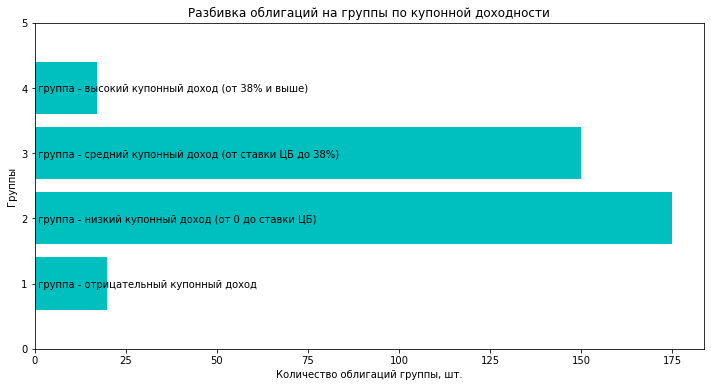

In [233]:
# строим график
t1 = pd.DataFrame(rb[['Profit_bins']].value_counts().reset_index()).sort_values('Profit_bins')
t1.columns = ['Profit', 'count']
t1.index = range(1,t1.shape[0]+1)

plt.figure(figsize=(12,6))

plt.barh(t1.index, t1['count'], color='c')

plt.ylabel("Группы")
plt.xlabel("Количество облигаций группы, шт.")

plt.title('Разбивка облигаций на группы по купонной доходности')

plt.ylim([0, 5])

plt.text(0, 0.94, " группа - отрицательный купонный доход")
plt.text(0, 1.94, " группа - низкий купонный доход (от 0 до ставки ЦБ)")
plt.text(0, 2.94, " группа - средний купонный доход (от ставки ЦБ до {}%)".format(int(rb['Profit'].quantile(0.95))+1))
plt.text(0, 3.94, " группа - высокий купонный доход (от {}% и выше)".format(int(rb['Profit'].quantile(0.95))+1))

plt.plot()

In [234]:
# выбираем ликвидные и доходные (больше ставки ЦБ) облигации на текущий момент
top = rb[(rb.PRICE >= 100) & (rb.Profit >= cb) & (rb.COUPONFREQUENCY >= 4)]
top = top[['SECID', 'SHORTNAME', 'MATDATE', 'FACEVALUE', 'COUPONFREQUENCY', 'COUPONDATE', 'COUPONPERCENT',
           'OFFERDATE', 'PRICE', 'PRICE_RUB', 'Nalog', 'Profit']].reset_index()
top = top.drop('index', axis=1)
# top.index = range(1, top.shape[0]+1)
top

,SECID,SHORTNAME,MATDATE,FACEVALUE,COUPONFREQUENCY,COUPONDATE,COUPONPERCENT,OFFERDATE,PRICE,PRICE_RUB,Nalog,Profit
0,RU000A101D96,РуСол клВ,2031-02-15,885.92,4.0,2022-11-15,15.342,2031-02-15,100.00,890.01,92.488333,21.293579
1,RU000A104JF6,ПушкПЗБО1,2026-02-09,1000.00,4.0,2022-11-14,14.000,2026-02-09,101.83,1022.52,77.836164,14.112844
2,RU000A104K37,СибЭнМаш01,2025-02-13,1000.00,4.0,2022-11-17,15.000,2025-02-13,100.06,1003.89,96.484932,19.838239
3,RU000A104KS7,РКС2Р2,2025-02-18,1000.00,4.0,2022-11-22,15.000,2025-02-18,100.07,1001.93,96.484932,20.072001
4,RU000A1053W3,ГЛОРАКС 01,2025-08-18,1000.00,4.0,2022-11-21,14.000,2025-08-18,101.08,1012.33,77.836164,15.260621


[]

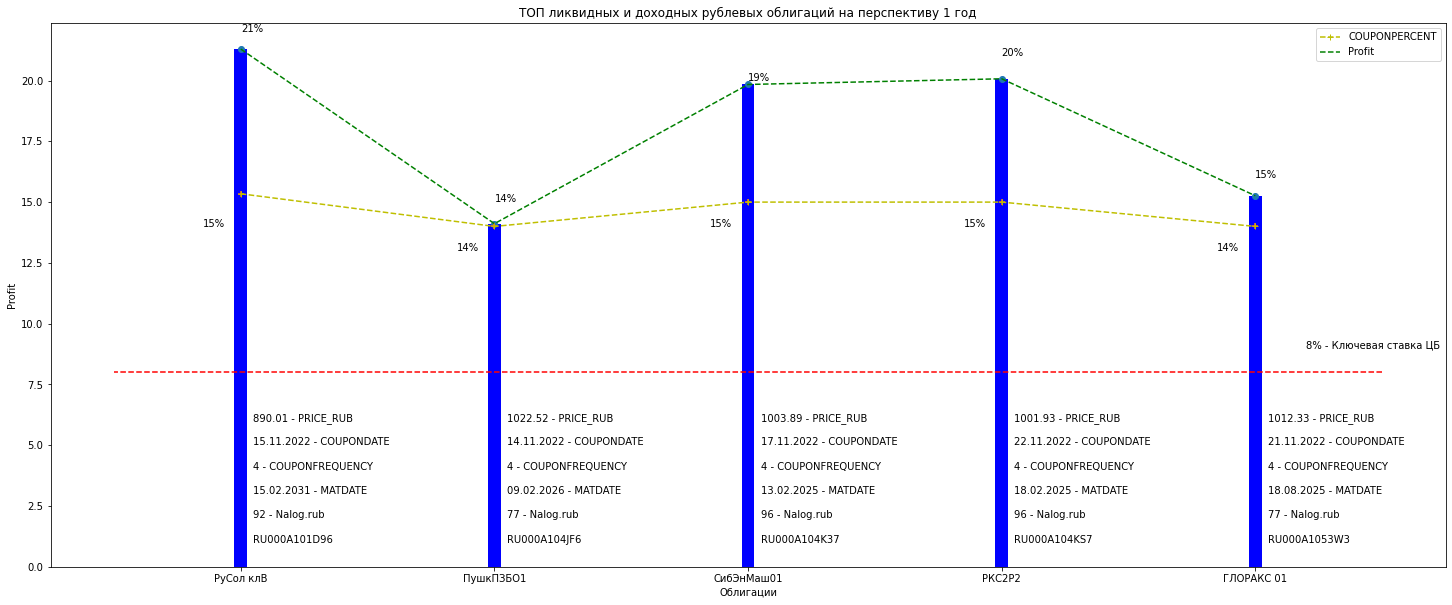

In [240]:
# строим график ликвидных и доходных (больше ставки ЦБ) облигаций на текущий момент
plt.figure(figsize=(25,10))

plt.bar(top.SHORTNAME, top.Profit, width = 0.05, color='b')
plt.scatter(top.SHORTNAME, top.Profit)
plt.scatter(top.SHORTNAME, top.COUPONPERCENT, marker="+")
plt.plot(top.SHORTNAME, top.COUPONPERCENT, 'y--', label='COUPONPERCENT', marker="+")
plt.plot(top.SHORTNAME, top.Profit, 'g--', label='Profit')
plt.plot((top.shape[0]-0.5,-0.5), (cb,cb), 'r--')


plt.ylabel("Profit")
plt.xlabel("Облигации")

plt.title('ТОП ликвидных и доходных рублевых облигаций на перспективу 1 год')

for i in range(0,top.shape[0]):
        plt.text(i, int(top.Profit[i]+1), "{}%".format(int(top.Profit[i])))
        plt.text(i-0.15, int(top.COUPONPERCENT[i]-1), "{}%".format(int(top.COUPONPERCENT[i])))
        plt.text(i+0.05, 6, "{} - PRICE_RUB".format(top.PRICE_RUB[i]))
        plt.text(i+0.05, 5, "{} - COUPONDATE".format(top.COUPONDATE[i].strftime('%d.%m.%Y')))
        plt.text(i+0.05, 4, "{} - COUPONFREQUENCY".format(int(top.COUPONFREQUENCY[i])))
        plt.text(i+0.05, 3, "{} - MATDATE".format(top.MATDATE[i].strftime('%d.%m.%Y')))
        plt.text(i+0.05, 2, "{} - Nalog.rub".format(int(top.Nalog[i])))
        plt.text(i+0.05, 1, "{}".format(top.SECID[i]))
                
plt.text(top.shape[0]-0.8, cb+1, '{}% - Ключевая ставка ЦБ'.format(int(cb)))

plt.legend()
plt.plot()

Покупка с ИИС

Покупая ОФЗ, физическое лицо также может инвестировать через индивидуальный инвестиционный счет (ИИС).

Преимущество ИИС перед обычным брокерским счетом состоит в возможности получить налоговый вычет.

Вычет типа «А». Инвестор имеет право вернуть 13% от суммы внесенных средств на ИИС. Максимально налоговый вычет составляет 52 тысячи рублей. Соответственно, льгота может быть предоставлена на сумму не более 400 тысяч рублей.

Вычет типа «Б». Подобное налоговое послабление позволяет инвестору освободить от налогообложения всю прибыль, полученную в результате финансовых сделок через ИИС.

По российскому законодательству запрещено иметь более одного ИИС. К тому же с индивидуального инвестиционного счета нельзя выводить денежные средства в течение трех лет после его открытия. В противном случае необходимо будет вернуть государству все средства, полученные от применения того или иного типа налогового вычета.